In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import walk

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, SGD
from keras.utils import Sequence

Using TensorFlow backend.


In [66]:
class data_generator(Sequence):
    """
    Generator class to process large datasets.
    """

    def __init__(self, filenames, feat_col_labels, target_col_labels, batch_size):
        self.filenames = filenames
        self.feat_col_labels = feat_col_labels
        self.target_col_labels = target_col_labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        data = pd.read_csv(self.filenames[idx])# * self.batch_size:(idx + 1) * self.batch_size])
        batch_x = data[self.feat_col_labels].values
        batch_y = data[self.target_col_labels].values

        return np.array(batch_x), np.array(batch_y)

In [16]:
def simple_model():
    """Define simple model"""
    # create model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(96,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='linear'))
    # show info
    model.summary()
    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics = ['mean_absolute_error'])
    return model

### Training

In [5]:
# define training parameters
batch_size = 32
num_epochs = 30

In [6]:
# define dataset directory
data_dir = '/media/feliximmohr/Storage/master_thesis/generated/database/' 
# load filelist
filelist = []
for (dirpath, dirnames, filenames) in walk(data_dir):
    filelist.extend(filenames)
    
# load column labels only
column_label = pd.read_csv(data_dir+filelist[1], nrows=1).columns.tolist()
feature_label = [s for s in column_label if ("ILD"  in s or "ITD" in s or "IC" in s)]
target_label = 'Localization_Azimuth'

In [18]:
num_train_samples = 20*720000
num_valid_samples = 10*720000

In [67]:
# model.fit_generator on batches of dataset

model = simple_model()

train_filenames = [data_dir + s for s in filelist[0:20]]
valid_filenames = [data_dir + s for s in filelist[20:30]]

# define generators
train_batch_generator = data_generator(train_filenames, feature_label, target_label, 1)
valid_batch_generator = data_generator(valid_filenames, feature_label, target_label, 1)

history = model.fit_generator(generator = train_batch_generator,
                              steps_per_epoch = (num_train_samples),# // batch_size),
                              epochs = num_epochs,
                              verbose = 1,
                              validation_data = valid_batch_generator,
                              validation_steps = (num_valid_samples),# // batch_size),
                              use_multiprocessing = True,
                              workers = 2,
                              max_queue_size = 32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 128)               12416     
_________________________________________________________________
dense_44 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 129       
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
5
1
4
0


Process ForkPoolWorker-68:
Process ForkPoolWorker-66:


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/feliximmohr/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/feliximmohr/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/feliximmohr/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/feliximmohr/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/feliximmohr/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/feliximmohr/anaconda3/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/feliximmohr/anaconda3/lib/python3.7/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQU

KeyboardInterrupt


In [20]:
# model.fit on entire dataset

# load data
data = pd.read_csv(data_dir+filelist[63])

# create model
model = simple_model()
# split data into test and train data
train, test = train_test_split(data, test_size=0.3)
x_train = train[feature_label].values
y_train = train[target_label].values
x_test = test[feature_label].values
y_test = test[target_label].values

# start training
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               12416     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 29,057
Trainable params: 29,057
Non-trainable params: 0
_________________________________________________________________
Train on 504000 samples, validate on 216000 samples
Epoch 1/30
504000/504000 [==============================] - 45s 90us/step - loss: 1037.0904 - mean_absolute_error: 11.1196 - val_loss: 1004.7555 - val_mean_absolute_error: 10.3158
Epoch 2/30
504000/504000 [==============================] - 45s 90us/step - loss: 987.5117 - mean_absolute_error: 9.8604 - val_loss: 972.1070 - val_mean_absolute_error: 9

### Evaluation

In [21]:
# evaluate model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 961.9842245983548
Test accuracy: 8.950497492860865


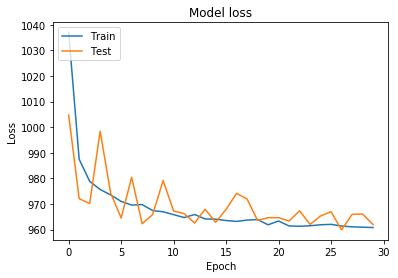

In [22]:
# plot train history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:
test_data = pd.read_csv(data_dir+filelist[64])
test_features = test_data[feature_label].values
test_targets = test_data[target_label].values

test_results = model.predict(test_features)

In [44]:
test_results[114000:114100]

array([[-43.09604 ],
       [-41.97457 ],
       [-40.27143 ],
       [-42.40689 ],
       [-51.25809 ],
       [-47.795383],
       [-41.680664],
       [-40.04858 ],
       [-41.20377 ],
       [-43.527718],
       [-43.70068 ],
       [-43.241783],
       [-43.41486 ],
       [-43.59616 ],
       [-43.008316],
       [-45.22016 ],
       [-47.073814],
       [-45.07606 ],
       [-45.924603],
       [-42.87644 ],
       [-44.86952 ],
       [-42.4915  ],
       [-44.54048 ],
       [-43.189713],
       [-38.54527 ],
       [-45.6082  ],
       [-46.454388],
       [-43.094475],
       [-45.79251 ],
       [-42.413013],
       [-45.669136],
       [-45.346924],
       [-42.12968 ],
       [-43.989872],
       [-45.188152],
       [-43.114494],
       [-44.529297],
       [-44.518604],
       [-40.383392],
       [-42.95581 ],
       [-37.9258  ],
       [-45.27312 ],
       [-42.866634],
       [-42.425434],
       [-44.214466],
       [-39.650444],
       [-42.392776],
       [-46.4

In [42]:
# Save history to json file
import json
with open('file.json', 'w') as f:
    json.dump(history.history, f)

In [43]:
from keras.models import load_model

model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model